<a href="https://colab.research.google.com/github/benjams-235/Sealion_obj_detection/blob/main/obj_detect_sealion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detecting Sealions in Aerial Images 

The image and annotation data in this notebook came from https://www.viametoolkit.org

In [1]:

import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt


In [3]:
#read in csv of paths, boxes, and labels
df = pd.read_csv('/content/annotations.viame.csv', skiprows=[0,1], header=None)
print(df.shape)
df.head()

(28219, 11)


,0,1,2,3,4,5,6,7,8,9,10
0,255484,20160623_SSLC0073_C.jpg,0,4975,925,5156,1027,1.0,-1,Bull,1.0
1,255485,20160623_SSLC0073_C.jpg,0,5479,1745,5568,1933,1.0,-1,Bull,1.0
2,255486,20160623_SSLC0073_C.jpg,0,4829,1952,5006,2042,1.0,-1,Bull,1.0
3,255487,20160623_SSLC0073_C.jpg,0,4528,2077,4640,2255,1.0,-1,Bull,1.0
4,255488,20160623_SSLC0073_C.jpg,0,5163,458,5309,537,1.0,-1,Bull,1.0


In [6]:
# renaming columns and adding target label numbers
df = df.rename(columns={1: 'image_name', 2:'img_id', 3:'x_min', 4:'y_min', 5:'x_max', 6:'y_max', 9:'label' })
df = df[['image_name','img_id','x_min','y_min','x_max','y_max','label']]
print(df['label'].unique())


['Bull' 'Juv' 'SAM' 'Fem' 'Ignore' 'Pup' 'Dead Pup']


In [7]:
label_dict = {'Bull':1, 'Juv':2, 'SAM':3, 'Fem':4, 'Ignore':5, 'Pup':6, 'Dead Pup':7}
df['label_num'] = df['label'].map(label_dict)
df.head()

,image_name,img_id,x_min,y_min,x_max,y_max,label,label_num
0,20160623_SSLC0073_C.jpg,0,4975,925,5156,1027,Bull,1
1,20160623_SSLC0073_C.jpg,0,5479,1745,5568,1933,Bull,1
2,20160623_SSLC0073_C.jpg,0,4829,1952,5006,2042,Bull,1
3,20160623_SSLC0073_C.jpg,0,4528,2077,4640,2255,Bull,1
4,20160623_SSLC0073_C.jpg,0,5163,458,5309,537,Bull,1


In [8]:
# Making sure bounding boxes are on the image
df.loc[df['x_max'] > 5760, 'x_max'] = 5760
df.loc[df['y_max'] > 3840, 'y_max'] = 3840
df.loc[df['x_min'] < 0, 'x_min'] = 0
df.loc[df['y_min'] < 0, 'y_min'] = 0
df.head()

,image_name,img_id,x_min,y_min,x_max,y_max,label,label_num
0,20160623_SSLC0073_C.jpg,0,4975,925,5156,1027,Bull,1
1,20160623_SSLC0073_C.jpg,0,5479,1745,5568,1933,Bull,1
2,20160623_SSLC0073_C.jpg,0,4829,1952,5006,2042,Bull,1
3,20160623_SSLC0073_C.jpg,0,4528,2077,4640,2255,Bull,1
4,20160623_SSLC0073_C.jpg,0,5163,458,5309,537,Bull,1


In [9]:
print(df.shape)

(28219, 8)


In [10]:
conditions_x = [df.x_min.eq(df.x_max), df.x_min.gt(df.x_max), df.x_min.lt(df.x_max)]
choices_x = [100, 1, 0]
df['x_wrong'] = np.select(conditions_x, choices_x)

conditions_y = [df.y_min.eq(df.y_max), df.y_min.gt(df.y_max), df.y_min.lt(df.y_max)]
choices_y = [100, 1, 0]
df['y_wrong'] = np.select(conditions_y, choices_y)
df

,image_name,img_id,x_min,y_min,x_max,y_max,label,label_num,x_wrong,y_wrong
0,20160623_SSLC0073_C.jpg,0,4975,925,5156,1027,Bull,1,0,0
1,20160623_SSLC0073_C.jpg,0,5479,1745,5568,1933,Bull,1,0,0
2,20160623_SSLC0073_C.jpg,0,4829,1952,5006,2042,Bull,1,0,0
3,20160623_SSLC0073_C.jpg,0,4528,2077,4640,2255,Bull,1,0,0
4,20160623_SSLC0073_C.jpg,0,5163,458,5309,537,Bull,1,0,0
...,...,...,...,...,...,...,...,...,...,...
28214,20160709_SSLP0065_C.JPG,411,300,1470,356,1516,Pup,6,0,0
28215,20160709_SSLP0065_C.JPG,411,860,3138,4131,3836,Ignore,5,0,0
28216,20160709_SSLP0065_C.JPG,411,3,3523,868,3840,Ignore,5,0,0
28217,20160709_SSLP0065_C.JPG,411,0,399,82,3527,Ignore,5,0,0


In [11]:
print(df['y_wrong'].value_counts())
print(df['x_wrong'].value_counts())

0    28219
Name: y_wrong, dtype: int64
0    28219
Name: x_wrong, dtype: int64


In [12]:
print(df['image_name'].unique()[0:30])
filter_img = df['image_name'].unique()[0:30]

['20160623_SSLC0073_C.jpg' '20160623_SSLC0106_C.JPG'
 '20160623_SSLC0279_C.JPG' '20160623_SSLC0280_C.JPG'
 '20160623_SSLC0282_C.JPG' '20160623_SSLC0284_C.JPG'
 '20160623_SSLC0361_C.JPG' '20160623_SSLC0465_C.JPG'
 '20160623_SSLC0467_C.JPG' '20160623_SSLC0514_C.JPG'
 '20160623_SSLC0516_C.JPG' '20160623_SSLC0518_C.JPG'
 '20160623_SSLP0483_C.JPG' '20160623_SSLP0485_C.JPG'
 '20160624_SSLC0014_C.JPG' '20160624_SSLC0120_C.JPG'
 '20160624_SSLC0209_C.JPG' '20160624_SSLC0211_C.JPG'
 '20160624_SSLC0213_C.JPG' '20160624_SSLC0217_C.JPG'
 '20160624_SSLC0321_C.JPG' '20160624_SSLC0323_C.JPG'
 '20160624_SSLC0352_C.JPG' '20160624_SSLC0354_C.JPG'
 '20160624_SSLC0356_C.JPG' '20160624_SSLC0358_C.JPG'
 '20160624_SSLC0380_C.JPG' '20160624_SSLC0383_C.JPG'
 '20160624_SSLC0384_C.JPG' '20160624_SSLC0385_C.JPG']


In [13]:
#create file to input into torch dataset
df_anno = df[df['image_name'].isin(filter_img)]
df_anno = df_anno[['image_name', 'img_id', 'x_min','y_min','x_max','y_max','label_num']]
print(df_anno.shape)
print(df_anno.head())

(2272, 7)
                image_name  img_id  x_min  y_min  x_max  y_max  label_num
0  20160623_SSLC0073_C.jpg       0   4975    925   5156   1027          1
1  20160623_SSLC0073_C.jpg       0   5479   1745   5568   1933          1
2  20160623_SSLC0073_C.jpg       0   4829   1952   5006   2042          1
3  20160623_SSLC0073_C.jpg       0   4528   2077   4640   2255          1
4  20160623_SSLC0073_C.jpg       0   5163    458   5309    537          1


In [14]:
#getting annotation file

data = df_anno

images = []
annotations = []

def image(row):
    image = {}
    image["id"] = row.img_id
    image["file_name"] = row.image_name
    return image

def annotation(row):
    annotation = {}
    area = (row.x_max -row.x_min)*(row.y_max - row.y_min)
    #annotation["segmentation"] = []
    annotation["iscrowd"] = 0
    annotation["area"] = area
    annotation["image_id"] = row.img_id
    annotation["bbox"] = [row.x_min, row.y_min, row.x_max, row.y_max]
    annotation["label"] = row.label_num
    return annotation

for row in data.itertuples():
    annotations.append(annotation(row))

image_df = data.drop_duplicates(subset=['image_name']).sort_values(by='img_id')
for row in image_df.itertuples():
    images.append(image(row))

data_anno = {}
data_anno["images"] = images
data_anno["annotations"] = annotations

save_json_path = 'annotations.json'

json.dump(data_anno, open(save_json_path, "w"), indent=4)

In [15]:
# Opening JSON file
f = open('annotations.json')
  
# return JSON object as a dictionary
d = json.load(f)
  
print(len(d['annotations'])) 
print(d['images'][0])  
print(d['annotations'][0])  
# Closing file
f.close()

2272
{'id': 0, 'file_name': '20160623_SSLC0073_C.jpg'}
{'iscrowd': 0, 'area': 18462, 'image_id': 0, 'bbox': [4975, 925, 5156, 1027], 'label': 1}


# Custom Dataset Class

In [16]:
import os
import torch
import torch.utils.data
from PIL import Image
from torchvision.io import read_image

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, annotations_file, transforms=None, target_transform=None):
        self.image_dir = image_dir
        self.anno_file = annotations_file
        self.transforms = transforms
        self.target_transform = target_transform
        # load all image files 
        self.imgs = list(sorted(os.listdir(image_dir,)))
       

    def __getitem__(self, idx):
        # load images 
        img_path = os.path.join(self.image_dir, self.imgs[idx])
        img = Image.open(img_path).convert('RGB')
        f = open(self.anno_file)
        anno = json.load(f)
        # get bounding box coordinates for each 
        d_objs = [d for d in anno['annotations'] if d['image_id'] == idx]
        boxes = []
        label_l = []
        for anno_dict in d_objs:
            xmin = anno_dict['bbox'][0]
            xmax = anno_dict['bbox'][2]
            ymin = anno_dict['bbox'][1]
            ymax = anno_dict['bbox'][3]
            boxes.append([xmin, ymin, xmax, ymax])
            class_label= anno_dict['label']
            label_l.append(class_label)
        boxes = torch.tensor(boxes, dtype=torch.float32)
        
        labels = torch.tensor(label_l, dtype=torch.int64)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((len(d_objs)), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms:
            img = self.transforms(img)

        if self.target_transform:
            label = self.target_transform(label)

        return img, target

    def __len__(self):
        return len(self.imgs)

# Data Loaders

In [17]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [19]:
import torch.utils.data as data
import torch, torchvision
import torchvision.transforms as T


# Set the path to your image directory and annotations file
image_dir = '/content/images/'

annotations_file = '/content/annotations.json'

# Define your transformations for the dataset
transform = torchvision.transforms.Compose([
    #T.Resize((224, 224)),
    T.ToTensor(),
    #T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Create a CustomDataset object for training data
all_data = CustomDataset(image_dir, annotations_file, transforms=transform, target_transform=None)

# Split the dataset into training and test sets
train_size = int(0.8 * len(all_data))
test_size = len(all_data) - train_size
train_dataset, test_dataset = data.random_split(all_data, [train_size, test_size])

# Create validation set
train_s = int(0.8 * len(train_dataset))
val_s = len(train_dataset) - train_s
train_data, val_data = data.random_split(train_dataset, [train_s, val_s])

# Define your dataloaders for the datasets
batch_size = 2

train_loader = data.DataLoader(train_data, batch_size=batch_size, shuffle=False, num_workers=2, collate_fn=collate_fn)
test_loader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, collate_fn=collate_fn)
val_loader = data.DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=2, collate_fn=collate_fn)

In [20]:
print(len(train_data))
print(len(val_data))
print(len(test_dataset))

19
5
6


In [22]:


import torchvision.transforms.functional as F


plt.rcParams["savefig.bbox"] = 'tight'


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [23]:
img_tensor = train_data[1][0]
#print(img_tensor)
box_tensor = train_data[1][1]['boxes']  

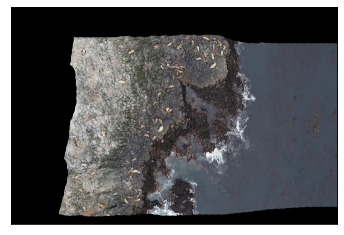

In [24]:
show(img_tensor)

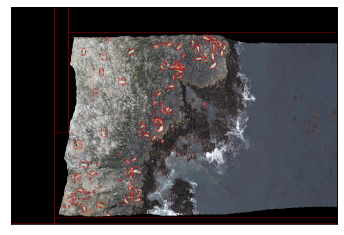

In [25]:
from torchvision.utils import draw_bounding_boxes

img_int = torchvision.transforms.functional.convert_image_dtype(img_tensor, torch.uint8)
# draw bounding box and fill color
img = draw_bounding_boxes(img_int, box_tensor, width=5, colors='red', fill=False)
show(img)

# Load Model

In [26]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained pre-trained 
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 8  
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [27]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has 8 classes background and 7 sealion types
num_classes = 8

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=3,gamma=0.1)

# Training and Validation

In [32]:
# function for running training iterations
def train(train_data_loader, model):
    print('Training')
    model.train()
    train_itr = 0
    train_loss_list = []
    
    for images, targets in train_data_loader:
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        train_loss_list.append(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        train_itr += 1
    
    print(train_loss_list) #optimizer.param_groups[0]["lr"])  
    return train_loss_list

In [29]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 38.5 MB/s eta 0:00:00


In [30]:
# function for running validation iterations
import torchmetrics
from torchmetrics.detection.mean_ap import MeanAveragePrecision

def validate(valid_data_loader, model):
    print('Validating')
    model.eval()
    val_itr=0
    val_loss_list = []
    
    for images, targets in valid_data_loader:
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        with torch.no_grad():
            pred = model(images)
        for single_pred in pred:
          keep = torchvision.ops.nms(single_pred['boxes'], single_pred['scores'], 0.3)
          single_pred['boxes'] = single_pred['boxes'][keep]
          single_pred['labels'] = single_pred['labels'][keep]
          single_pred['scores'] = single_pred['scores'][keep]

        metric = MeanAveragePrecision()
        metric.update(pred, targets)
    output = metric.compute()

    from pprint import pprint
    pprint(output)
    return output


In [33]:
# let's train it for 3 epochs

num_epochs = 3

for epoch in range(num_epochs):
   
    #this is simple train function to get loss
    train(train_loader, model)

    #this is a simple eval function to get map metrics
    validate(val_loader, model)

# saving model state
model_path = 'model_state_1'
torch.save(model.state_dict(), model_path)

Training
[1.9064512252807617, 1.808079719543457, 1.6870514154434204, 1.4969545602798462, 1.6625425815582275, 1.6286238431930542, 1.8794138431549072, 1.9822170734405518, 1.7995434999465942, 1.5935616493225098]
Validating
{'map': tensor(0.0189),
 'map_50': tensor(0.0453),
 'map_75': tensor(0.0061),
 'map_large': tensor(0.0489),
 'map_medium': tensor(0.0444),
 'map_per_class': tensor(-1.),
 'map_small': tensor(-1.),
 'mar_1': tensor(0.),
 'mar_10': tensor(0.0267),
 'mar_100': tensor(0.1000),
 'mar_100_per_class': tensor(-1.),
 'mar_large': tensor(0.0700),
 'mar_medium': tensor(0.2667),
 'mar_small': tensor(-1.)}
Training
[1.7536734342575073, 1.718674659729004, 1.4910508394241333, 1.6813864707946777, 1.5292259454727173, 1.3288379907608032, 1.7601605653762817, 1.710605263710022, 1.586228370666504, 1.4959945678710938]
Validating
{'map': tensor(0.0593),
 'map_50': tensor(0.2602),
 'map_75': tensor(0.0061),
 'map_large': tensor(0.0894),
 'map_medium': tensor(0.0400),
 'map_per_class': tensor(-

In [ ]:
#loading model - run load model cells first 
model_path = 'model_state_1'
model.load_state_dict(torch.load(model_path))

# Prediction

In [34]:
# pick one image from the test set
img, target = test_dataset[1]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

In [35]:
prediction

[{'boxes': tensor([[ 978.1373, 1051.6224, 1058.2466, 1145.9923],
          [ 935.9838, 1152.9240, 1027.3180, 1225.8228],
          [1088.9264, 1006.7762, 1190.1121, 1085.8856],
          [ 556.8195,  440.5974,  618.6555,  557.8256],
          [1707.0275, 3308.4807, 1836.7417, 3426.3848],
          [ 876.5195,  936.1323,  955.8965, 1036.1992],
          [1236.0277, 1039.6757, 1352.0715, 1134.1262],
          [ 883.3567, 1064.2220,  961.4446, 1144.7170],
          [1180.8326, 1443.4135, 1256.7173, 1523.7051],
          [ 818.5908, 1567.0193,  895.1329, 1689.7671],
          [1349.7552, 3061.0664, 1477.6537, 3205.0051],
          [1166.9238, 1319.8564, 1228.9192, 1431.3821],
          [ 525.3374,  919.7078,  726.6443, 1020.8671],
          [1241.4379, 1056.3827, 1338.7826, 1120.7860],
          [1357.7236, 3071.0769, 1465.2762, 3196.7947],
          [ 534.7287,  926.0382,  708.5881, 1015.3262],
          [ 805.7368, 1229.9517,  939.7934, 1300.5634],
          [ 791.1849, 1550.9424,  911.7

In [36]:
# Applying NMS
keep = torchvision.ops.nms(prediction[0]['boxes'], prediction[0]['scores'], 0.3)
prediction[0]['boxes'] = prediction[0]['boxes'][keep]
prediction[0]['labels'] = prediction[0]['labels'][keep]
prediction[0]['scores'] = prediction[0]['scores'][keep]
prediction

[{'boxes': tensor([[ 978.1373, 1051.6224, 1058.2466, 1145.9923],
          [ 935.9838, 1152.9240, 1027.3180, 1225.8228],
          [1088.9264, 1006.7762, 1190.1121, 1085.8856],
          [ 556.8195,  440.5974,  618.6555,  557.8256],
          [1707.0275, 3308.4807, 1836.7417, 3426.3848],
          [ 876.5195,  936.1323,  955.8965, 1036.1992],
          [1236.0277, 1039.6757, 1352.0715, 1134.1262],
          [ 883.3567, 1064.2220,  961.4446, 1144.7170],
          [1180.8326, 1443.4135, 1256.7173, 1523.7051],
          [ 818.5908, 1567.0193,  895.1329, 1689.7671],
          [1349.7552, 3061.0664, 1477.6537, 3205.0051],
          [1166.9238, 1319.8564, 1228.9192, 1431.3821],
          [ 525.3374,  919.7078,  726.6443, 1020.8671],
          [ 805.7368, 1229.9517,  939.7934, 1300.5634],
          [ 938.6676, 1348.1499, 1028.6309, 1460.0317],
          [1227.1403, 1228.1049, 1278.8689, 1304.5930],
          [ 977.0818, 1496.8945, 1102.4285, 1577.7786],
          [ 984.2459, 1278.0867, 1067.0

In [37]:

pred_boxes = prediction[0]['boxes']

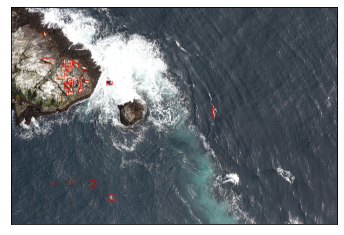

In [38]:
img_int = torchvision.transforms.functional.convert_image_dtype(img, torch.uint8)
# draw bounding box and fill color
pred_img = draw_bounding_boxes(img_int, pred_boxes, width=7, colors='red', fill=False)
show(pred_img)

In [39]:
# compare to true labels
true_boxes = target['boxes']

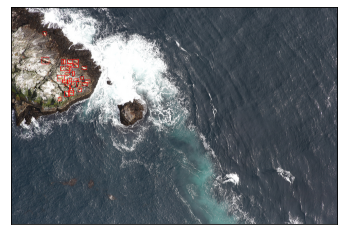

In [40]:
# compare to true labels  
img = draw_bounding_boxes(img_int, true_boxes, width=7, colors='red', fill=False)
show(img)

# Test

In [44]:
#function for test on training set

def test(test_data_loader, model):
    print('Testing')
    model.eval()
    val_itr=0
    val_loss_list = []
    
    for images, targets in test_data_loader:
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        with torch.no_grad():
            pred = model(images)

        for single_pred in pred:
          keep = torchvision.ops.nms(single_pred['boxes'], single_pred['scores'], 0.3)
          single_pred['boxes'] = single_pred['boxes'][keep]
          single_pred['labels'] = single_pred['labels'][keep]
          single_pred['scores'] = single_pred['scores'][keep]

        metric = MeanAveragePrecision(class_metrics=True)
        metric.update(pred, targets)
  
    output = metric.compute()
  
  
    from pprint import pprint
    pprint(output)
    
    #return output

In [45]:
test(test_loader, model)

Testing
{'map': tensor(0.0248),
 'map_50': tensor(0.1189),
 'map_75': tensor(0.0078),
 'map_large': tensor(0.0136),
 'map_medium': tensor(0.0230),
 'map_per_class': tensor([0.0257, 0.0190, 0.0000, 0.0544]),
 'map_small': tensor(-1.),
 'mar_1': tensor(0.0100),
 'mar_10': tensor(0.0204),
 'mar_100': tensor(0.0407),
 'mar_100_per_class': tensor([0.0250, 0.0247, 0.0000, 0.1132]),
 'mar_large': tensor(0.0476),
 'mar_medium': tensor(0.0329),
 'mar_small': tensor(-1.)}
